In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Overview

In [2]:
df = pd.read_parquet('/kaggle/input/demand-forecasting-duck-product/problem2_filter_transaction_price.parquet')

print(df.shape)
df.head()

(540570, 21)


,key_cv_p,WeekMon,OrderDate,DeliveryDate,WarehouseBKey,CustomerBKey,CustomerArea3NameLocal,CLASS_PRICE,ProductForPlan1,ProductForPlan8,...,ProductBKey,MODEL_4,region,OrderWeight,DeliveryWeight,WeightUnit,price_key,cls_prd_price,prd_price,p10_avg_price
0,2000382733+000000000023042143,2024-02-05,2024-02-08,2024-02-08,242-OPRCDN039,2000382733,ตลาดสด,CLSPRUNO2,Duck,Main Product,...,000000000023042143,ภาคเหนือบน เขต 1,ภาคเหนือบน,24.0,24.00,KG,CLSPRUNO2+000000000023042143,1734.00,648.250000,396.335021
1,2000360209+000000000023103882,2024-12-30,2025-01-02,2025-01-02,242-OPRCDN039,2000360209,ตลาดนัด,CLSPRUNO1,Duck,Main Product,...,000000000023103882,ภาคเหนือบน เขต 1,ภาคเหนือบน,35.1,31.45,KG,CLSPRUNO1+000000000023103882,1543.05,744.432059,648.634939
2,2000098337+000000000023103882,2024-11-04,2024-11-09,2024-11-09,242-OPRCDN039,2000098337,ตลาดสด,CLSPRUNO2,Duck,Main Product,...,000000000023103882,ภาคเหนือบน เขต 1,ภาคเหนือบน,20.0,15.59,KG,CLSPRUNO2+000000000023103882,257.30,767.753235,633.561761
3,2000147806+000000000023010737,2024-07-01,2024-06-29,2024-07-01,242-OPRCD0850,2000147806,ค้าส่ง,CLSPRSOT5,Duck,Main Product,...,000000000023010737,ภาคใต้ เขต 2,ภาคใต้,24.0,24.00,KG,CLSPRSOT5+000000000023010737,142.00,624.039062,357.368436
4,2000173747+000000000023103882,2024-12-02,2024-12-03,2024-12-03,242-OPRCDN039,2000173747,Restaurant,CLSPRUNO2,Duck,Main Product,...,000000000023103882,ภาคเหนือบน เขต 1,ภาคเหนือบน,20.0,15.80,KG,CLSPRUNO2+000000000023103882,257.30,735.214412,609.856324


- remove key_cv_p which didn't appear in test set

In [3]:
test_df = pd.read_csv('/kaggle/input/demand-forecasting-duck-product/problem2_test.csv')
test_df['key_cv_p'] = test_df['CustomerBKey'].astype('str') + '+0000000000' + test_df['ProductBKey'].astype('str')
df = df[ df['key_cv_p'].isin(test_df['key_cv_p'].unique()) ].reset_index(drop=True)
df.shape

(382661, 21)

In [4]:
# top_key = df.groupby(['key_cv_p'])\
#                 .agg({'OrderDate': 'nunique'})\
#                 .sort_values(by='OrderDate', ascending=False)
# top_key = top_key[ top_key['OrderDate'] >= 200 ].index.tolist()
# len(top_key)

## EDA
- insight: week seasonality/ positive trends

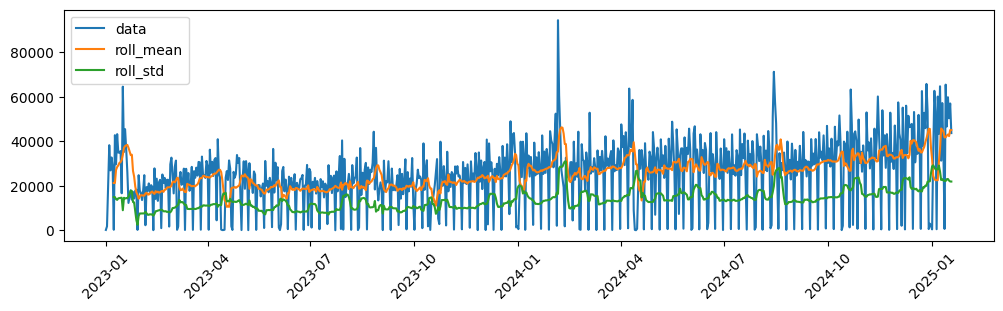

In [6]:
filtered_df = df[ (df['OrderDate'] >= '2023-01-01') ]
filtered_df = filtered_df.groupby('OrderDate')['OrderWeight'].sum().reset_index()
filtered_df['roll_mean'] = filtered_df['OrderWeight'].shift().rolling(7).mean()
filtered_df['roll_std'] = filtered_df['OrderWeight'].shift().rolling(7).std()

plt.figure(figsize=(12, 3))
plt.plot(filtered_df['OrderDate'], filtered_df['OrderWeight'], label='data')
plt.plot(filtered_df['OrderDate'], filtered_df['roll_mean'], label='roll_mean')
plt.plot(filtered_df['OrderDate'], filtered_df['roll_std'], label='roll_std')
plt.legend()
plt.xticks(rotation=45)
plt.show()

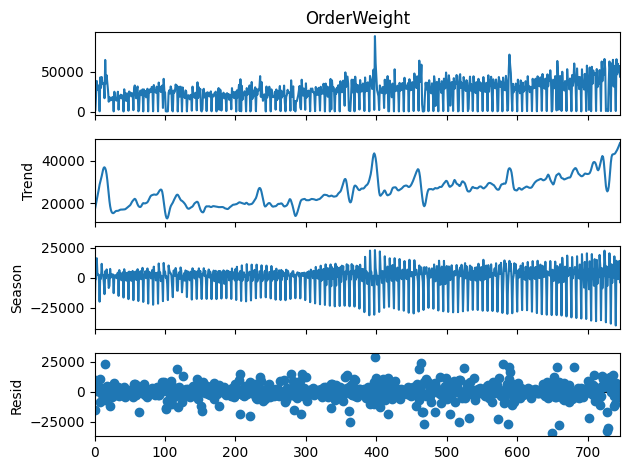

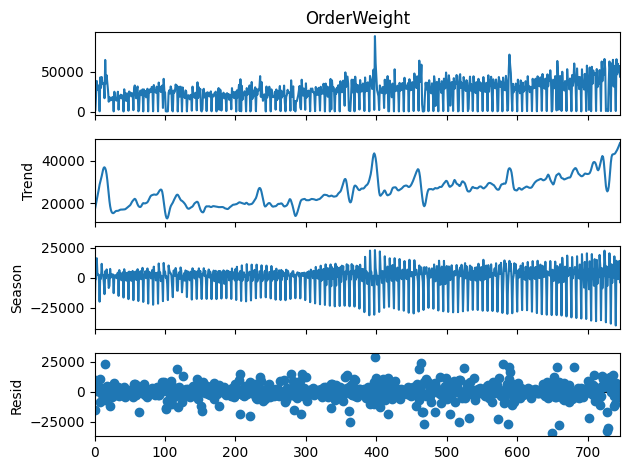

In [8]:
from statsmodels.tsa.seasonal import STL

stl = STL(filtered_df['OrderWeight'], period=7)
res = stl.fit()
res.plot()

**Data Prep**
- resampling the missing date (date with no order)
- filter only 2024++ (reduce RAM usage)

In [9]:
df = df[ df['OrderDate'] >= '2024-01-01' ]
full_date_range = pd.date_range(start='2024-01-01', end='2025-01-18', freq='D')
item_ids = df['key_cv_p'].unique()

expanded_index = pd.MultiIndex.from_product(
    [item_ids, full_date_range],
    names=['key_cv_p', 'OrderDate']
)

full_df = pd.DataFrame(index=expanded_index).reset_index()
resampled_df = full_df.merge(df, on=['key_cv_p', 'OrderDate'], how='left')
resampled_df['OrderWeight'].isnull().sum()

3649933

## Model Training

In [10]:
!pip install uv
!uv pip install -q autogluon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 79.2 MB/s eta 0:00:00:00:0100:01
Using Python 3.11.11 environment at: /usr
Resolved 226 packages in 2.79s                                       
   Building seqeval==1.2.2                                             
   Building seqeval==1.2.2                                     
   Building nvidia-ml-py3==7.352.0
   Building seqeval==1.2.2                                     
   Building nvidia-ml-py3==7.352.0
⠙ Preparing packages... (0/47)
   Building seqeval==1.2.2--------     0 B/99.32 KiB           
   Building nvidia-ml-py3==7.352.0
⠙ Preparing packages... (0/47)
   Building seqeval==1.2.2-------- 14.91 KiB/99.32 KiB         
   Building nvidia-ml-py3==7.352.0
⠙ Preparing packages... (0/47)
   Building seqeval==1.2.2-------- 14.91 KiB/99.32 KiB         
   Building nvidia-ml-py3==7.352.0
⠙ Preparing packages... (0/47)
packaging            ------------------------------     0 B/63.92 KiB
   Building seqeval==1.2.2-------- 14

In [11]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

ts_data = TimeSeriesDataFrame.from_data_frame(
    resampled_df[['key_cv_p', 'OrderDate', 'OrderWeight']],
    id_column='key_cv_p',
    timestamp_column='OrderDate',
)
ts_data.rename(columns={"OrderWeight": "target"}, inplace=True)
ts_data = ts_data.fillna(0)
ts_data

target
item_id                       timestamp         
2000360209+000000000023103882 2024-01-01     0.0
                              2024-01-02     0.0
                              2024-01-03     0.0
                              2024-01-04     0.0
                              2024-01-05     0.0
...                                          ...
2000376676+000000000023103972 2025-01-14     0.0
                              2025-01-15     0.0
                              2025-01-16     0.0
                              2025-01-17     0.0
                              2025-01-18     0.0

[3901534 rows x 1 columns]

In [12]:
predictor = TimeSeriesPredictor(
    prediction_length=21,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MAE",
    freq='D',
)

predictor.fit(
    ts_data,
    presets="best_quality",
    time_limit=600,
    hyperparameters={
        "Chronos": [
            {
                "model_path": "amazon/chronos-bolt-base",
                "ag_args": {"name_suffix": "ZeroShot"},
            },
            {
                "model_path": "amazon/chronos-bolt-base",
                "covariate_regressor": "CAT",
                "target_scaler": "standard",
                "ag_args": {"name_suffix": "WithRegressor"},
            },
        ],
    },
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to '/kaggle/working/autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
GPU Count:          2
Memory Avail:       28.25 GB / 31.35 GB (90.1%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MAE,
 'freq': 'D',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'amazon/chronos-bolt-base'},
                                 {'ag_args': {'name_suffix': 'WithRegressor'},
                                  'covariate_regressor': 'CAT',
                                  'model_path': 'amazon/chronos-bolt-base',
                      

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	-3.6079       = Validation score (-MAE)
	49.75   s     = Training runtime
	20.78   s     = Validation (prediction) runtime
Training timeseries model ChronosWithRegressor[amazon__chronos-bolt-base]. Training for up to 255.6s of the 511.3s of remaining time.
	Skipping covariate_regressor since the dataset contains no covariates or static features.
	Skipping covariate_regressor since the dataset contains no covariates or static features.
	-3.6079       = Validation score (-MAE)
	26.87   s     = Training runtime
	24.82   s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'ChronosWithRegressor[amazon__chronos-bolt-base]': 1.0}
	-3.6079       = Validation score (-MAE)
	15.02   s     = Training runtime
	24.82   s     = Validation (prediction) runtime
Training complete. Models trained: ['ChronosZeroShot[amazon__chronos-bolt-base]', 'ChronosWithRegressor[amazon__chronos-bolt-base]', 'WeightedEnsemble']
Total runtime: 141.75 s
Best model: ChronosWithRe

In [ ]:
y_pred = predictor.predict(ts_data)
print(y_pred.shape)
y_pred.head()

## Test set

In [14]:
test_df = pd.read_csv('/kaggle/input/demand-forecasting-duck-product/problem2_test.csv')

test_df['key_cv_p'] = test_df['CustomerBKey'] + '+0000000000' + test_df['ProductBKey'].astype('str')
test_df.rename(columns={'OrderDate': 'timestamp', 'key_cv_p': 'item_id'}, inplace=True)

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], format='%Y-%m-%d')

print(test_df.shape)
test_df.head()

(263130, 10)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,timestamp,CustomerBKey,ProductBKey,horizon,MODEL_4,ProductForPlan1,ProductForPlan10,OrderWeight,item_id
0,f3cd25af-da90-427d-97bb-b846800d5eee,2025-01-19,020P,23013118,1,กรุงเทพฯ เขต4,Duck,เป็ดพะโล้,0.0,020P+000000000023013118
1,059cc414-0587-4f07-bb58-3aa2c8dfa402,2025-01-20,020P,23013118,2,กรุงเทพฯ เขต4,Duck,เป็ดพะโล้,0.0,020P+000000000023013118
2,c1de6281-3fc1-495a-aac9-45d818cd1bea,2025-01-21,020P,23013118,3,กรุงเทพฯ เขต4,Duck,เป็ดพะโล้,0.0,020P+000000000023013118
3,3a8267d7-8fc5-4a24-8005-e206f49f453a,2025-01-22,020P,23013118,4,กรุงเทพฯ เขต4,Duck,เป็ดพะโล้,NaN,020P+000000000023013118
4,7eea9f7a-da37-4b1c-a183-696d80f4acec,2025-01-23,020P,23013118,5,กรุงเทพฯ เขต4,Duck,เป็ดพะโล้,NaN,020P+000000000023013118


In [15]:
merged_test = test_df.merge(y_pred.reset_index()[['item_id', 'timestamp', 'mean']],
              on=['item_id', 'timestamp'], how='left',
              suffixes=('', '_pred'))
merged_test['mean'] = merged_test['mean'].fillna(0)
temp = merged_test.isnull().sum()
temp[ temp > 0 ]

OrderWeight    263127
dtype: int64

## Final Submission

In [16]:
submission = pd.read_csv('/kaggle/input/demand-forecasting-duck-product/problem2_test.csv')
submission['OrderWeight'] = merged_test['mean']

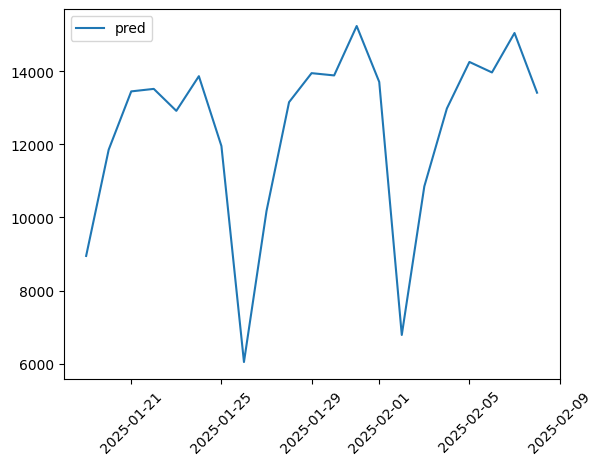

In [17]:
filtered_df = df[ df['OrderDate'] >= '2024-01-01' ]
submission['OrderDate'] = pd.to_datetime(submission['OrderDate'], format='%Y-%m-%d')

# plt.plot(filtered_df.groupby('OrderDate')['OrderWeight'].sum(), label='data')
plt.plot(submission.groupby('OrderDate')['OrderWeight'].sum(), label='pred')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [18]:
submission.to_csv('chronos-bolt-base.csv', index=False)